In [1]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset


In [25]:
df = pd.read_csv("data.csv")

In [26]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [28]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


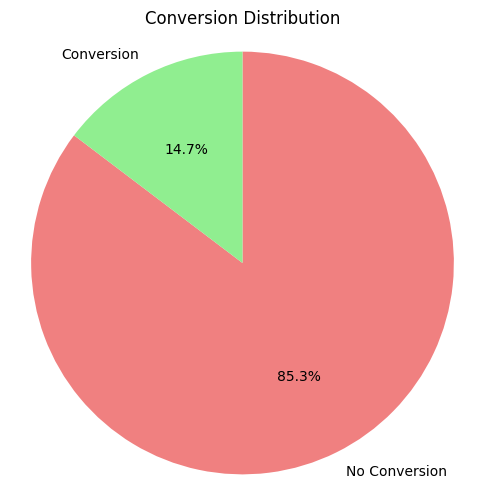

In [29]:
# Get value counts
conversion_counts = df['conversion'].value_counts()
labels = conversion_counts.index.map({0: 'No Conversion', 1: 'Conversion'})
sizes = conversion_counts.values
colors = ['lightcoral', 'lightgreen']

# Plot
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title('Conversion Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


<ipython-input-30-3402541267>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='pastel')


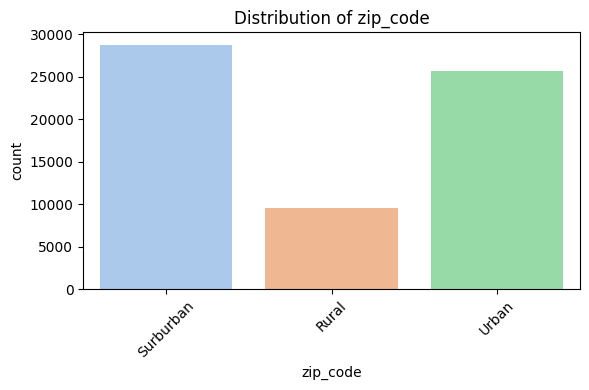

<ipython-input-30-3402541267>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='pastel')


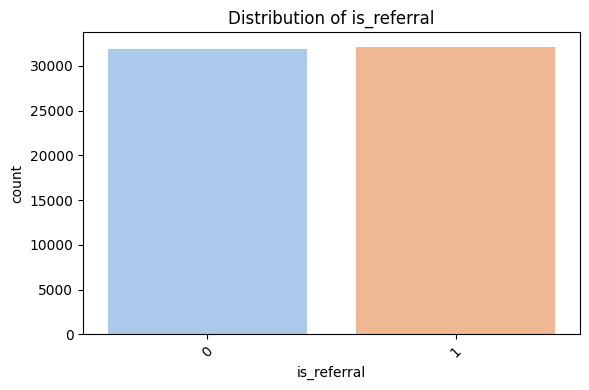

<ipython-input-30-3402541267>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='pastel')


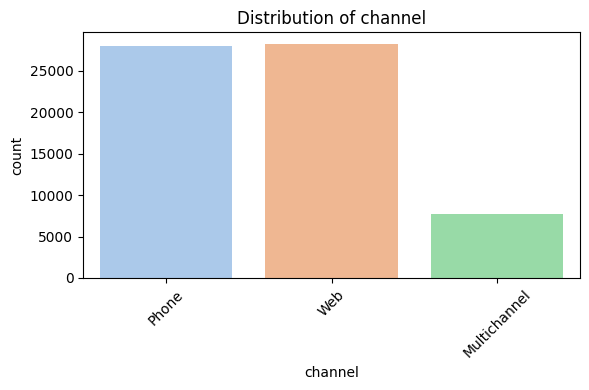

<ipython-input-30-3402541267>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='pastel')


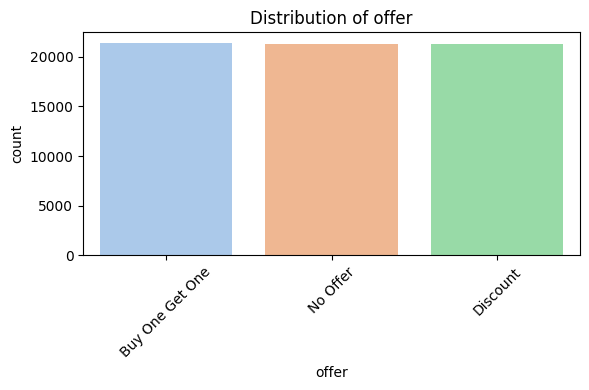

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

categorical_columns = ['zip_code', 'is_referral', 'channel', 'offer']

for col in categorical_columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col, palette='pastel')
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [31]:
from sklearn.preprocessing import LabelEncoder

# Columns to encode
label_cols = ['channel', 'zip_code', 'offer']

# Initialize encoder
le = LabelEncoder()

# Apply label encoding
for col in label_cols:
    df[col] = le.fit_transform(df[col])

# Verify
df[label_cols].head()


,channel,zip_code,offer
0,1,1,0
1,2,0,2
2,2,1,0
3,2,0,1
4,2,2,0


In [44]:
X = df.drop('conversion', axis=1)
y = df['conversion']

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


# 3. Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_resampled))

# Convert to tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Datasets and Loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

Before SMOTE: [43685  7515]
After SMOTE: [43685 43685]


In [45]:
class MarketingNN(nn.Module):
    def __init__(self, input_dim):
        super(MarketingNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = MarketingNN(X_train_tensor.shape[1])


In [46]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [49]:
epochs = 30
losses = []
accuracies = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        # Model output: [32, 1]
        outputs = model(batch_X).squeeze(1)  # Convert to [32]
        loss = criterion(outputs, batch_y.float())

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Accuracy
        predicted = (outputs > 0.5).float()
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

    accuracy = correct / total
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch 1/30, Loss: 0.6616, Accuracy: 0.5971
Epoch 2/30, Loss: 0.6566, Accuracy: 0.6032
Epoch 3/30, Loss: 0.6555, Accuracy: 0.6062
Epoch 4/30, Loss: 0.6540, Accuracy: 0.6059
Epoch 5/30, Loss: 0.6538, Accuracy: 0.6084
Epoch 6/30, Loss: 0.6527, Accuracy: 0.6085
Epoch 7/30, Loss: 0.6525, Accuracy: 0.6095
Epoch 8/30, Loss: 0.6521, Accuracy: 0.6105
Epoch 9/30, Loss: 0.6513, Accuracy: 0.6109
Epoch 10/30, Loss: 0.6510, Accuracy: 0.6121
Epoch 11/30, Loss: 0.6508, Accuracy: 0.6105
Epoch 12/30, Loss: 0.6508, Accuracy: 0.6137
Epoch 13/30, Loss: 0.6497, Accuracy: 0.6138
Epoch 14/30, Loss: 0.6497, Accuracy: 0.6127
Epoch 15/30, Loss: 0.6496, Accuracy: 0.6138
Epoch 16/30, Loss: 0.6494, Accuracy: 0.6123
Epoch 17/30, Loss: 0.6489, Accuracy: 0.6141
Epoch 18/30, Loss: 0.6489, Accuracy: 0.6130
Epoch 19/30, Loss: 0.6484, Accuracy: 0.6140
Epoch 20/30, Loss: 0.6489, Accuracy: 0.6136
Epoch 21/30, Loss: 0.6483, Accuracy: 0.6149
Epoch 22/30, Loss: 0.6481, Accuracy: 0.6139
Epoch 23/30, Loss: 0.6474, Accuracy: 0.61

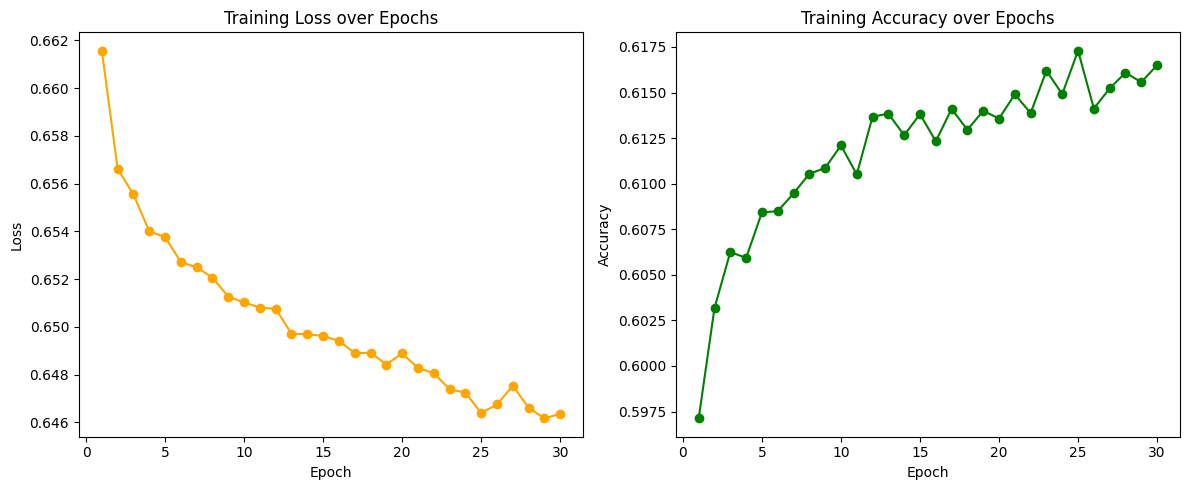

In [50]:
plt.figure(figsize=(12,5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), losses, marker='o', color='orange')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), accuracies, marker='o', color='green')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


In [51]:
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor)
    preds_binary = (preds >= 0.5).float()

# Accuracy and Report
print("Confusion Matrix:\n", confusion_matrix(y_test_tensor, preds_binary))
print("\nClassification Report:\n", classification_report(y_test_tensor, preds_binary))




Confusion Matrix:
 [[6297 4624]
 [ 714 1165]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.58      0.70     10921
           1       0.20      0.62      0.30      1879

    accuracy                           0.58     12800
   macro avg       0.55      0.60      0.50     12800
weighted avg       0.80      0.58      0.64     12800



In [52]:
!pip install gradio

In [56]:


import gradio as gr
import torch
import torch.nn as nn


# 🔁 Load trained model
input_dim = 8
model = MarketingNN(input_dim)

model.eval()

# 💡 Label encoders (manual encoding from training)
def encode_inputs(recency, history, used_discount, used_bogo, zip_code, is_referral, channel, offer):
    zip_dict = {'Urban': 0, 'Suburban': 1, 'Rural': 2}
    channel_dict = {'Web': 0, 'Phone': 1, 'Multichannel': 2}
    offer_dict = {'Buy One Get One': 0, 'Discount': 1, 'No Offer': 2}

    encoded = [
        float(recency),
        float(history),
        int(used_discount),
        int(used_bogo),
        zip_dict[zip_code],
        int(is_referral),
        channel_dict[channel],
        offer_dict[offer]
    ]
    return torch.tensor(encoded, dtype=torch.float).unsqueeze(0)  # Padding for 10 features if needed

# 🎯 Inference function
def predict_conversion(recency, history, used_discount, used_bogo, zip_code, is_referral, channel, offer):
    inputs = encode_inputs(recency, history, used_discount, used_bogo, zip_code, is_referral, channel, offer)
    with torch.no_grad():
        output = model(inputs)
        prediction = int(output.item() >= 0.5)
        prob = output.item()
        return f"Predicted Conversion: {'✅ Yes (1)' if prediction == 1 else '❌ No (0)'}"

# 🎨 Gradio UI
iface = gr.Interface(
    fn=predict_conversion,
    inputs=[
        gr.Number(label="Recency"),
        gr.Number(label="History"),
        gr.Radio([0, 1], label="Used Discount?"),
        gr.Radio([0, 1], label="Used BOGO?"),
        gr.Radio(['Urban', 'Suburban', 'Rural'], label="Zip Code"),
        gr.Radio([0, 1], label="Is Referral?"),
        gr.Radio(['Web', 'Phone', 'Multichannel'], label="Channel"),
        gr.Radio(['Buy One Get One', 'Discount', 'No Offer'], label="Offer Type"),
    ],
    outputs=gr.Textbox(label="Conversion Prediction"),
    title="🛍️ Marketing Campaign Conversion Predictor"
)

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a63fbe1d52c119d392.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
